In [1]:
# This file is part of pydidas.
#
# Copyright 2023 - 2024, Helmholtz-Zentrum Hereon
# SPDX-License-Identifier: GPL-3.0-only
#
# pydidas is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License version 3 as
# published by the Free Software Foundation.
#
# Pydidas is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Pydidas. If not, see <http://www.gnu.org/licenses/>.

"""
The dataset module includes the Dataset subclasses of numpy.ndarray with additional
embedded metadata.
"""

__author__ = "Gudrun Lotze"
__copyright__ = "Copyright 2024, Helmholtz-Zentrum Hereon"
__license__ = "GPL-3.0-only"
__maintainer__ = "Gudrun Lotze"
__status__ = "Development"

In [2]:
from pathlib import Path
import os
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from pydidas.core import Dataset
from pydidas.data_io import import_data
%matplotlib inline


import importlib
import sys

from pydidas.version import version
print('Pydidas version: ', version)

from dataclasses import dataclass

from scipy.optimize import curve_fit



fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/stress_strain.py'
spec = importlib.util.spec_from_file_location('stress_strain', fname)
stress_strain = importlib.util.module_from_spec(spec)
spec.loader.exec_module(stress_strain)

# Check if the module object is created
if hasattr(stress_strain, '__file__'):
    print("Module was successfully loaded.")

# Inspect module attributes
print("Module attributes:", dir(stress_strain))

#We need to append the path to the sys.path to import the module
sys.path.append('/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins')

from  stress_strain import extract_d_spacing, chi_pos_verification, extract_d_spacing, ds_slicing, combine_sort_d_spacing_pos_neg, group_d_spacing_by_chi, extract_units, get_param_unit_at_index, idx_s2c_grouping, pre_regression_calculation



Pydidas version:  24.06.05
Module was successfully loaded.
Module attributes: ['Category', 'Dataset', 'IntEnum', 'Labels', 'StrEnum', '__author__', '__builtins__', '__cached__', '__copyright__', '__doc__', '__file__', '__license__', '__loader__', '__maintainer__', '__name__', '__package__', '__spec__', '__status__', 'chi_pos_unit_verification', 'chi_pos_verification', 'combine_sort_d_spacing_pos_neg', 'connected_components', 'csr_matrix', 'ds_slicing', 'extract_d_spacing', 'extract_units', 'get_param_unit_at_index', 'group_d_spacing_by_chi', 'idx_s2c_grouping', 'np', 'pre_regression_calculation']


UNSUPPORTED (log once): buildComputeProgram: cl2Metal failed


Auxiliary functions for plotting and main function

Wavelegth [A]
 0.110041890861
Energy [keV]
 112.67000000010138
Wavelength calculated [A] 0.1100418622980634
d_spacing.shape
 (25, 36)
🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿🍿
Dataset(
axis_labels: {
    0: 'y-z'
    1: 'chi'
    2: '0: position; 1: amplitude; 2: area; 3: FWHM; 4: background at peak; 5:
       total count intensity'},
axis_ranges: {
    0: array([-46.58, -46.48, ..., -44.28, -44.18])
    1: array([  0.,   5., ..., 170., 175.])
    2: array([0, 1, 2, 3, 4, 5], dtype=int32)},
axis_units: {
    0: 'mm'
    1: 'deg'
    2: ''},
metadata: {'indices': '[:]', 'dataset': 'entry/data/data'},
data_unit: ,
data_label: position / A; amplitude / cts; area / (cts *A); FWHM / A; background at peak / cts; total count intensity / cts,
array([[[1.083872e+00, 3.412543e+02, ..., 1.517860e+01, 1.214989e+03],
        [1.082855e+00, 4.573983e+02, ..., 2.011258e+01, 1.661932e+03],
        ...,
        [1.084043e+00, 3.349980e+02, ..., 1.080088e+01, 1.182022e+03],
        [1.084011e+00, 3.37908

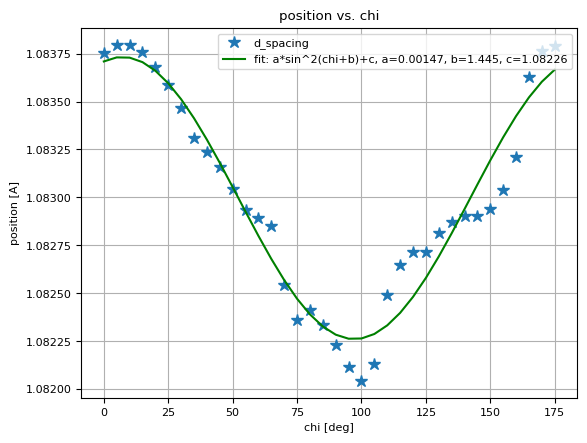

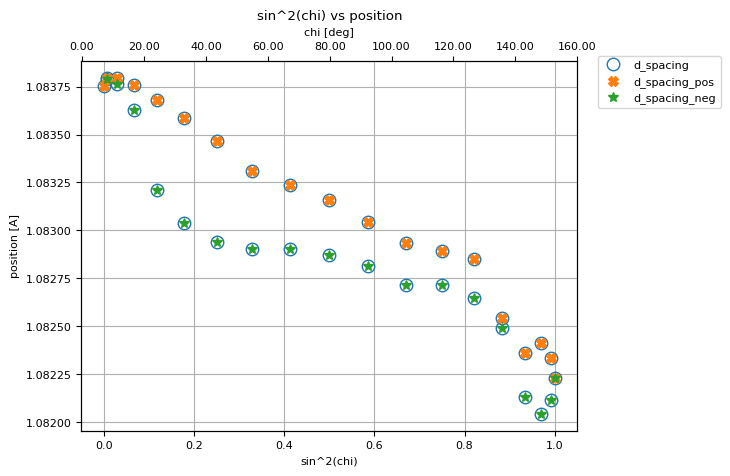

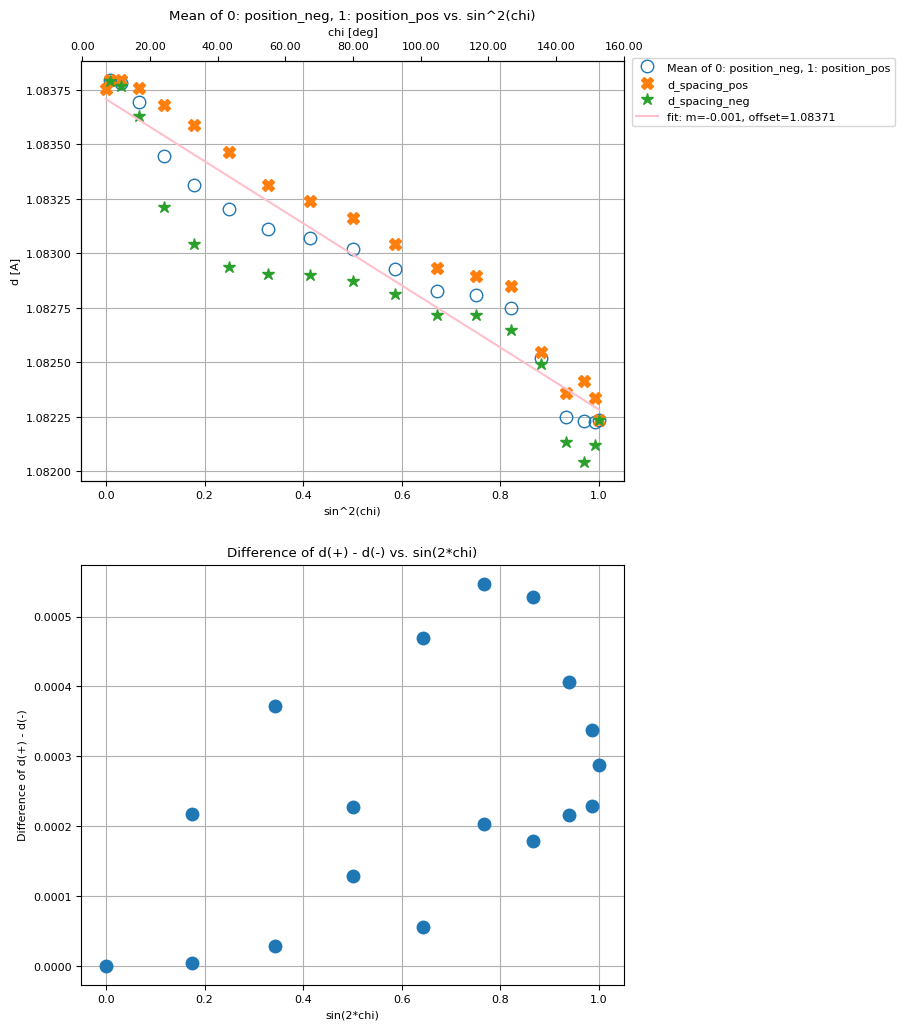

In [3]:
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def plot_sin2chi(chi):
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, linestyle='None', marker='o')
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs chi')
    ax.grid()
    fig.show()

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  


def plot_d_spacing_vs_chi_1d(ds, chi, scan_axis):
    
    print('ds.shape:', ds.shape)
    
    chi_key, (pos_key, pos_idx)  = chi_pos_verification(ds)
    
    fig, ax = plt.subplots()
    
    for pos in ds.axis_ranges[scan_axis]:
        # Extract d_spacing for the specific position
        d_spacing = ds[pos, :, ]
   

def plot_d_spacing_vs_chi_2d_2d(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """

    print('ds.shape:', ds.shape)
    
    fig, ax = plt.subplots()
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs chi for various x,y')
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
def plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi):
    
    mask = ~np.isnan(d_spacing_avg.array)
    x_data_filtered = d_spacing_avg.axis_ranges[0][mask]
    y_data_filtered = d_spacing_avg.array[mask]
    
    popt_reg_fit, pcov_reg_fit = curve_fit(regression_line_fit, x_data_filtered, y_data_filtered, maxfev=100000, sigma=0.001*np.ones(y_data_filtered.shape), absolute_sigma=False)    
    m_fit=popt_reg_fit[0]
    offset_fit=popt_reg_fit[1]
       
    
    
    
    import matplotlib.gridspec as gridspec
    # Create a GridSpec with explicit height ratios
    fig = plt.figure(figsize=(7, 12))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.2)  # Increase hspace for more vertical space

    # Create the subplots using ax[0] and ax[1]
    ax = [None, None]
    ax[0] = fig.add_subplot(gs[0])
    ax[1] = fig.add_subplot(gs[1])
    
    ax[0].plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label=f'{d_spacing_avg.data_label}', markerfacecolor='None', markersize=9)
    ax[0].plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=8)
    ax[0].plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=9)
    ax[0].plot(d_spacing_avg.axis_ranges[0], sim_regression_line(d_spacing_avg.axis_ranges[0], m_fit, offset_fit), color='pink', label=f'fit: m={m_fit:.3f}, offset={offset_fit:.5f}')
    ax[0].set_ylabel(f'd [{d_spacing_avg.data_unit}]')
    ax[0].set_xlabel(d_spacing_avg.axis_labels[0])
    ax[0].set_title(f'{d_spacing_avg.data_label} vs. {d_spacing_avg.axis_labels[0]}') #'sin^2(chi) vs d_spacing
    interval = 4
    x_index = np.arange(0, len(chi), interval)
    ax2top=ax[0].twiny()
    ax2top.set_xlim(ax[0].get_xlim())
    formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    ax2top.set_xticks(x_index)
    ax2top.set_xticklabels(formatted_labels)
    ax2top.set_xlabel('chi [deg]')
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.51, 1.02))
    
    ax[0].grid()
    
    ax[1].plot(d_spacing_diff.axis_ranges[0], d_spacing_diff.array, linestyle='None', marker='o', label=d_spacing_diff.data_label, markersize=9)
    ax[1].set_title(f'{d_spacing_diff.data_label} vs. {d_spacing_diff.axis_labels[0]}')
    ax[1].set_xlabel(f'{d_spacing_diff.axis_labels[0]}')
    ax[1].set_ylabel(f'{d_spacing_diff.data_label}')
    ax[1].grid()
    # Adjust the space between the subplots
    fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space    
    fig.show() 
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict



    
def create_dummy_dataset(delta_chi, chi_start, chi_stop, phase_shift, spatial_var=False):
       
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
    
    plot_sin2chi(chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #make up data label 
    data_labels= 'position / nm; area / (cts * nm); FWHM / nm;background at peak / cts; total count intensity / cts'
    
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
   
    result_array= generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=spatial_var, phase_shift=phase_shift)
    
    print('Result array shape\n', result_array.shape)
    ds = Dataset(result_array,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
         
    return (chi, ds)
    
    
@dataclass
class Real_Dataset_Info:
    path: Path
    fname: str
    
    def fpath(self) -> Path:
        return self.path / Path(self.fname)
  
    
def create_real_dataset(real_dataset_info: Real_Dataset_Info):
    
    path_to_wavelength = 'entry/pydidas_config/diffraction_exp/xray_wavelength'
    path_to_energy = 'entry/pydidas_config/diffraction_exp/xray_energy'
    
    with h5.File(real_dataset_info.fpath(), 'r') as f:
        wavelength = f[path_to_wavelength][()] #keV
        energy = f[path_to_energy][()] #Angstrom
    print('Wavelegth [A]\n', wavelength)
    print('Energy [keV]\n', energy)
        
    
    fpath=real_dataset_info.fpath()
    ds= import_data(fpath)
    
    #print(40*"\N{microbe}")
    #print(ds)
    #print(40*"\N{microbe}")
      
    #reverse_axis_labels={value: key for key, value in ds.axis_labels.items()}
    #if 'chi' in reverse_axis_labels:
    #    chi = ds.axis_ranges[reverse_axis_labels['chi']]
    #lse:
    #    raise ValueError('chi not found in axis_labels')
   
    chi_key, (pos_key, pos_idx) = chi_pos_verification(ds)
    chi=ds.axis_ranges[chi_key] 
     
    position = ds.array[:,:,pos_idx]
       
    #in this dataset 'position' is given in 2theta, not d_spacing
    #energy = 112.67000000010138 #keV
    wavelength_calculated = 12.39841662513396/energy #result in Angstrom, energy [keV]
    print('Wavelength calculated [A]', wavelength_calculated)
    if np.allclose(wavelength, wavelength_calculated):
        d_spacing = wavelength/(2*np.sin(np.deg2rad(position)/2))
        print('d_spacing.shape\n', d_spacing.shape)
    else: 
        raise ValueError('Wavelength in file does not match calculated wavelength')
       
    ds_new = ds.copy()
    ds_new[:,:,pos_idx] = d_spacing
    
    new_data_label =  'position / A; amplitude / cts; area / (cts *A); FWHM / A; background at peak / cts; total count intensity / cts' 
    ds_new.data_label = new_data_label

   
    return (chi, ds_new)
  
def sin2_fit(chi, a, b,c ):
    return a*np.sin(np.deg2rad(chi)+b)**2+c  

def sim_sin2(chi, a, b,c):
    return a*np.sin(np.deg2rad(chi)+b)**2+c

def regression_line_fit(s2c, m, offset):
    return m*s2c + offset

def sim_regression_line(s2c, m, offset):
    return m*s2c + offset
  
def main2():
      
    #real_dataset_info1= Real_Dataset_Info(path=Path('/Users/lotzegud/pydidas_training/Real_data_David/AM_AB_Line_1_x_z'), fname='node_04.h5')
    real_dataset_info1= Real_Dataset_Info(path=Path('/Users/lotzegud/pydidas_training/Real_data_David/AM_AB_Line_1_y_z'), fname='node_04.h5')

    chi, ds = create_real_dataset(real_dataset_info1)
    #which scan position? 
    x_id=12
   
      
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Dimensions of dataset.array: ', ds.array.ndim)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
    
    chi_key, (pos_key, pos_idx) = chi_pos_verification(ds)
    print('chi_key, pos_key, pos_idx:')
    print(chi_key, pos_key, pos_idx)

    ds1 = ds[x_id]
    chi, d_spacing = ds_slicing(ds1)    
    
    d_spacing_low=np.min(ds[x_id,:,pos_idx])
    popt, pcov = curve_fit(sin2_fit, chi, d_spacing,maxfev=100000, sigma=0.001*np.ones(chi.shape), absolute_sigma=False, bounds=((0, -2, d_spacing_low-0.5),(1, 2, d_spacing_low+0.5)))
    #print(f'a*sin^2(chi+b)+c')
    #print(f'a_fit={popt[0]}, b_fit={popt[1]}, c_fit={popt[2]}')
    a_fit=popt[0]
    b_fit=popt[1]
    c_fit=popt[2]
    
    
    axis_labels_dict = split_fit_labels(ds.axis_labels[pos_key])
    units=extract_units(ds)
    #print('units', units)
    #print(axis_labels_dict)

    fig, ax = plt.subplots()
    ax.plot(chi, d_spacing, linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.plot(chi, sim_sin2(chi, a_fit, b_fit, c_fit), color='green', label=f'fit: a*sin^2(chi+b)+c, a={a_fit:.5f}, b={b_fit:.3f}, c={c_fit:.5f}')
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{ds.axis_labels[chi_key]} [{ds.axis_units[chi_key]}]')    
    ax.set_title(f'{axis_labels_dict[pos_idx]} vs. {ds.axis_labels[chi_key]}')
    ax.grid()
    plt.legend()
    plt.show()
    
    #print(40*"\N{microbe}")
    #print(d_spacing)
    #print(40*"\N{microbe}")
    
        
    d_spacing_pos, d_spacing_neg=group_d_spacing_by_chi(d_spacing, chi)
    
    #print(40*"\N{Cherries}")
    #print('d_spacing_pos\n',d_spacing_pos)
    #print(40*"\N{palm tree}")
    #print('d_spacing_neg\n',d_spacing_neg)
    #print(40*"\N{Cherries}")
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{d_spacing_pos.axis_labels[0]}')
    ax.set_title(f'{d_spacing_pos.axis_labels[0]} vs {axis_labels_dict[pos_idx]}')
    interval = 4
    x_index = np.arange(0, len(chi), interval)
    ax2top=ax.twiny()
    ax2top.set_xlim(ax.get_xlim())
    formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    ax2top.set_xticks(x_index)
    ax2top.set_xticklabels(formatted_labels)
    ax2top.set_xlabel('chi [deg]')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
    ax.grid()
    fig.show()
    
    
    d_spacing_combined = combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    #print('d_spacing_combined\n', d_spacing_combined) 
     
    d_spacing_avg, d_spacing_diff = pre_regression_calculation(d_spacing_combined) 
    
     
    #print(40*"\N{aubergine}")
    #print(d_spacing_avg)
    #print(40*"\N{aubergine}")
 
        
    #Visualisation of pre regression calculation results
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi)   
    
    

def main():
    
    #Creating of dummy dataset
    #chi, ds = create_dummy_dataset(delta_chi=10, chi_start=-90, chi_stop=1, phase_shift=70, spatial_var=False)
    chi, ds = create_dummy_dataset(delta_chi=10, chi_start=-180, chi_stop=181, phase_shift=70, spatial_var=False)
    x_idx=3
    y_idx=4
   
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
    
    
    #visualisation
    #positions = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4)]
    #plot_d_spacing_vs_chi_2d(ds, chi, positions)
    #plot_d_spacing_vs_chi_2d(ds_no_spatial, chi, positions)
      
   
    
    #plot_d_spacing_vs_chi_2d(ds, chi, [(x_idx, y_idx)])
    
    
    # slice Dataset based on location
    ds1 = ds[x_idx, y_idx]
    print('Content of ds1 before noise addition\n', ds1.array[:,0])
          
    #Introducing seed and random noise for d_spacing
    ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
    #print('Shape of ds1 dataset\n', ds1.shape)
    #print('Content ds1 array after noise addition\n',  ds1.array[:,0])
    #print(ds1)
    
    
    #Introducing np.nan 
    #print('Content ds1 array',  ds1.array[:,0])
    #ds1.array[0:9:2,0] = np.nan
    #ds1.array[18:28:2,0] = np.nan
   
    fig, ax = plt.subplots()
    ax.plot(chi, ds1.array[:,0], linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.grid()
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('chi [deg]')
    ax.set_title('d_spacing vs. chi')
    fig.show()
          
    chi_key, (pos_key, pos_idx) = chi_pos_verification(ds1)
    print('chi_key, pos_key, pos_idx:')
    print(chi_key, pos_key, pos_idx)

    chi, d_spacing = ds_slicing(ds1)    
    
    print(40*"\N{microbe}")
    print(d_spacing)
    print(40*"\N{microbe}")
    
        
    d_spacing_pos, d_spacing_neg=group_d_spacing_by_chi(d_spacing, chi)
    
    #print(40*"\N{Cherries}")
    #print('d_spacing_pos\n',d_spacing_pos)
    #print(40*"\N{palm tree}")
    #print('d_spacing_neg\n',d_spacing_neg)
    #print(40*"\N{Cherries}")
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel('d [nm]')
    ax.set_xlabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs d_spacing')
    interval = 4
    x_index = np.arange(0, len(chi), interval)
    ax2top=ax.twiny()
    ax2top.set_xlim(ax.get_xlim())
    formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    ax2top.set_xticks(x_index)
    ax2top.set_xticklabels(formatted_labels)
    ax2top.set_xlabel('chi [deg]')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.03))
    ax.grid()
    fig.show()
    
    
    d_spacing_combined = combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    print('d_spacing_combined\n', d_spacing_combined) 
     
    d_spacing_avg, d_spacing_diff = pre_regression_calculation(d_spacing_combined) 
      
        
    #Visualisation of pre regression calculation results
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi)
    
    
  
        

if __name__ == "__main__":
    main2()
    #main()